In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

# Decision tree

Дерево решений - является одним из самых простых логических алгоритмов машинного обучения, данный алгоритм хорошо описывает механизм принятия решений (логических предикатах)

<img src="./img/Predicat.png">
  
Дерево решений представляет собой бинарное дерево построенное на предикатах  
Данные предикаты вычисляются с помощью критерия информативности признаков

<img src="./img/treegraph.gif">

### Алгоритм построения дерева
Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$\Large S = -\sum_{i=1}^{C}p_ilog_2p_i,$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот

Пример
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.

<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$.

В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$.

Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как

$$\large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$

где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился

$$\large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.

<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/>

Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная.
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее.

Так же в качестве критерия информативности часто используют неопределенность Джини
$$\large {S = -\sum_{i=1}^{C}p_i(1-p_i)}$$

В основном используются простые предикаты, но возможно использование линейных или метрических предикатов

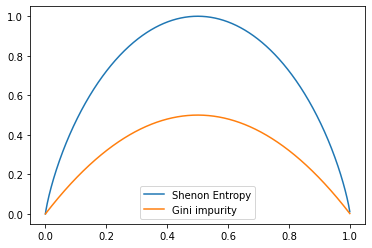

In [3]:
x = np.linspace(0.00001, 1, 999, endpoint=False)
plt.plot(x, -x*np.log2(x) - (1-x)*np.log2(1-x), label='Shenon Entropy');
plt.plot(x, 2*x*(1-x), label='Gini impurity');
plt.legend();

Как видно критерии качества не сильно отличаются друг от друга, поэтому на практике они дают очень близкие результаты

In [4]:
mlp.rcParams['figure.figsize'] = [16.0, 10.0]
plt.style.use('ggplot')

In [5]:
cancer_data = load_breast_cancer()

In [6]:
df = pd.DataFrame(cancer_data['data'], columns=cancer_data['feature_names'])

In [7]:
df['Target'] = cancer_data['target']

In [8]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [9]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Построем дерево решений над датасетом Breast Cancer - датасет в котором требуется предсказать наличие рака по медицинским показателям
Как и в случае с KNN будем использовать TSNE для визуализации границы предсказаний

In [10]:
tsne = TSNE(n_components=2)

In [11]:
scaler = StandardScaler()

In [12]:
x = scaler.fit_transform(df.drop('Target', axis=1))

In [13]:
x = tsne.fit_transform(x)

In [14]:
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))

Одним из основных параметров дерева решений является его глубина, посмотрим как граница предсказаний меняется с ее изменением

In [15]:
def print_border(max_depth):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(x, df['Target'])
    predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predict = predict.reshape(xx.shape)
    plt.pcolormesh(xx, yy, predict, cmap='Pastel2');
    sns.scatterplot(x[:, 0], x[:, 1], hue=df['Target'], palette=['red', 'blue']);

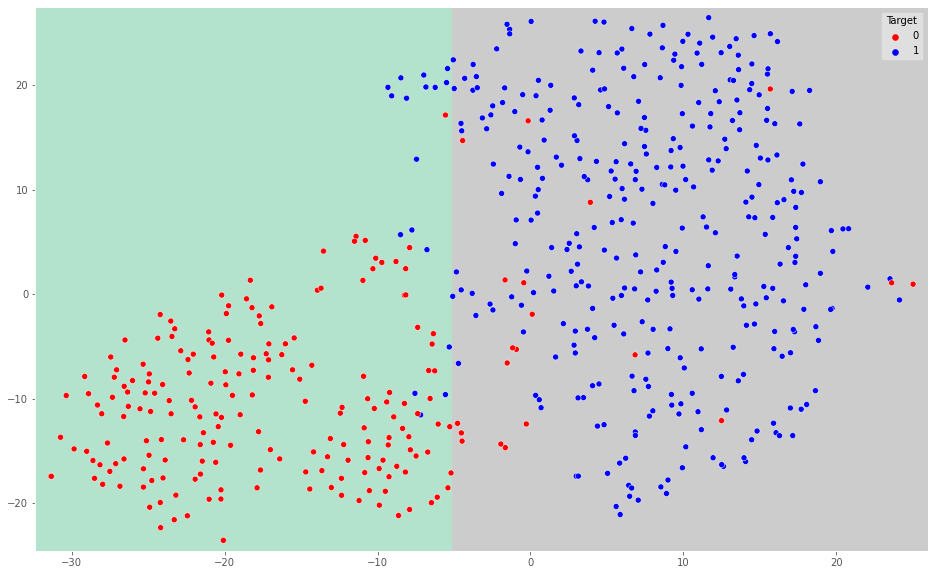

In [16]:
print_border(1)

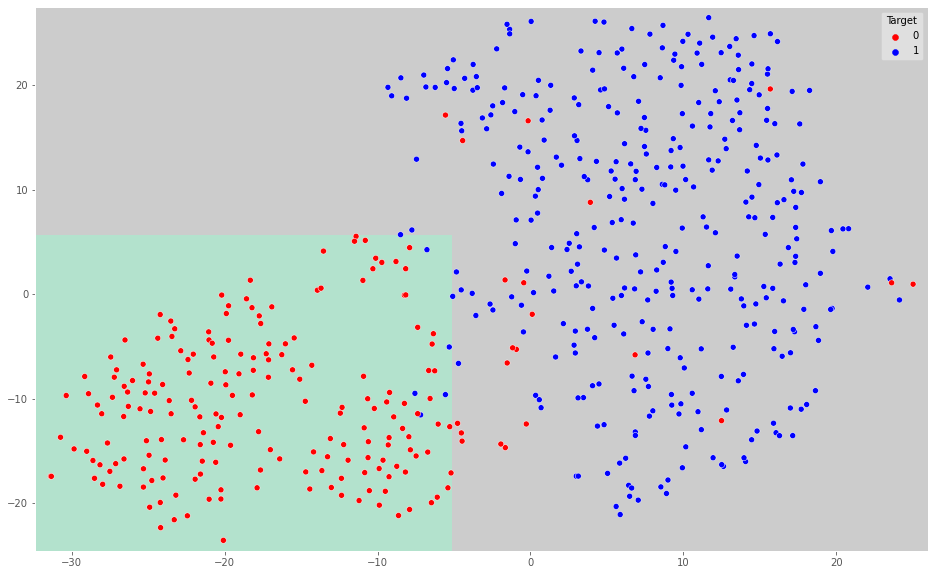

In [17]:
print_border(2)

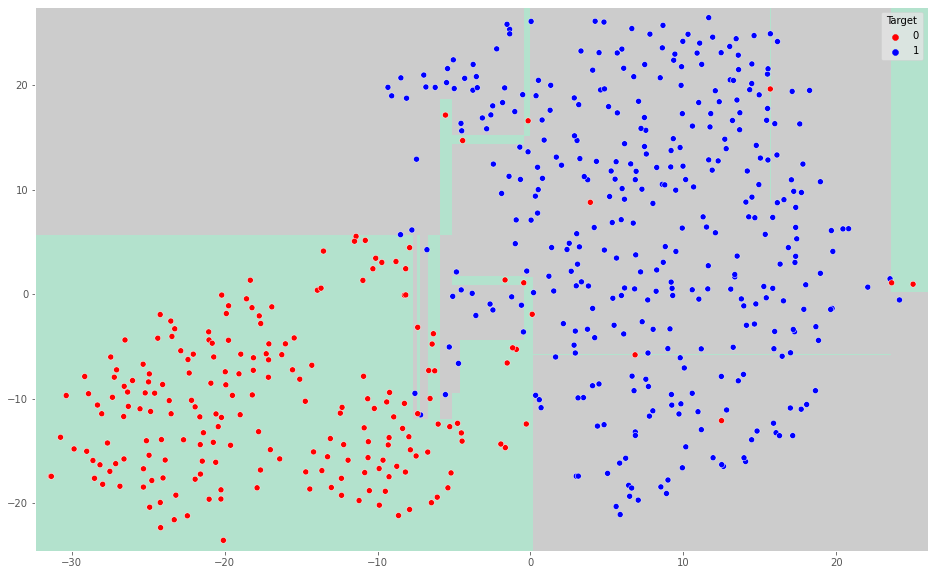

In [18]:
print_border(8)

Как видно с большой глубиной дерева мы строим очень специфические патерны в данных, что в дальнейшем приведет к переобучению

![](img/dt_outlier.png)

### Оптимизация количественных признаков

Как видно из текущего датасета все признаки являются количественными и просмотр всех возможных границ разделения займет очень много времени
В данном случае применяется следующая эвристика:

Сортируем данные по этому признаку

![](img/real_value_feature.png)

Расчитываем прирост информации в значениях где Таргет меняет свое значение (в качестве значения предиката берется 
среднее между соседями)
    
$$\large IG("x \leq 10.945") = S_0 - \frac{82}{569}S_1 - \frac{487}{569}S_2$$

$$\large S_0 = -0.627*\log_20.627-0.372*\log_20.372=0.952$$
$$\large S_1 = -1*\log_21=0$$
$$\large S_2 = -0.564*\log_20.564-0.435*\log_20.435=0.988$$

$$\large IG("x \leq 10.945") = 0.952 - \frac{82*0}{569} - \frac{487*0.988}{569} \approx 0.107$$

In [19]:
def inf_gain(feature, pred_value):
    
    s0 = df['Target'].value_counts()/df.shape[0]
    s0 = (-s0*np.log2(s0)).sum()
    l1 = df[df[feature] <= pred_value].shape[0]
    s1 = df[df[feature] <= pred_value]['Target'].value_counts()/l1
    s1 = (-s1*np.log2(s1)).sum()
    l2 = df[df[feature] > pred_value].shape[0]
    s2 = df[df[feature] > pred_value]['Target'].value_counts()/l2
    s2 = (-s2*np.log2(s2)).sum()
    ig = s0 - s1 * l1/df.shape[0] - s2 * l2/df.shape[0]
    return ig

In [20]:
inf_gain('mean radius', 10.945)

0.10710861299343044

In [21]:
inf_gain('mean radius', 13.39)

0.34438934456390174

## Настройка параметров дерева

Основные параметры для настройки
max_depth - максимальная глубина дерева
max_features - количество признаков на каждое разбиение
min_samples_leaf - минимальное количество данных в листе

Данные признаки можно настроить по <i>сетке</i>, воспользовавшись кросс валидацией

Кросс валидация - это итеративный процесс, при котором на каждой итерации выбирается одна подвыборка данных для тестирования модели (равна количеству данных/количество фолдов кросс валидации) и все остальные подвыборки используются для обучения

<img src="./img/5f_cv.png">
За подбор по сетке отвечает класс GridSearchCV модуля model_selection библиотеки sklearn

In [22]:
from sklearn.model_selection import GridSearchCV, KFold

In [23]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=100))
])

In [24]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__random_state', 'model__splitter'])

In [25]:
parameters = {
    'model__max_depth': np.arange(3, 9),
    'model__max_features': np.linspace(0.3, 1, 8),
    'model__min_samples_leaf': np.arange(5, 50, 5)
}

In [26]:
cv = GridSearchCV(estimator=pipe, param_grid=parameters, cv=KFold(5, shuffle=True), n_jobs=-1)

In [27]:
cv.fit(df.drop('Target', axis=1), df['Target'])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=100))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([3, 4, 5, 6, 7, 8]),
                         'model__max_features': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])})

In [28]:
cv.best_score_

0.9543393882937432

In [29]:
cv.best_params_

{'model__max_depth': 5,
 'model__max_features': 0.5,
 'model__min_samples_leaf': 5}

In [30]:
cv.best_estimator_.named_steps["model"]

DecisionTreeClassifier(max_depth=5, max_features=0.5, min_samples_leaf=5,
                       random_state=100)

Как видно с лучшими параметрами для этих данных мы получили качество 95%
Давайте посмотрим глазами на данное дерево, для этого экспотируем его в .dot формат с помощью функции export_graphviz

In [31]:
from sklearn.tree import export_graphviz

In [32]:
export_graphviz(cv.best_estimator_.named_steps["model"], feature_names=df.drop('Target', axis=1).columns, 
                out_file='tree.dot', filled=True)

<img src="./img/tree.png">

еще одним способом настройки глубины дерева является pruning, т.е. отрезание вершин где прирост информации меньше требуемого 

In [33]:
from sklearn.tree._tree import TREE_LEAF
from sklearn.model_selection import KFold

In [34]:
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

In [35]:
cv = KFold(shuffle=True, random_state=42, n_splits=5)
score = []
for train_idx, test_idx in cv.split(df['Target']):
    train_x = df.iloc[train_idx].drop('Target', axis=1)
    test_x = df.iloc[test_idx].drop('Target', axis=1)
    train_y = df.iloc[train_idx]['Target']
    test_y = df.iloc[test_idx]['Target']
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(train_x, train_y)
    prune_index(clf.tree_, 0, 5)
    pred = clf.predict(test_x)
    score.append((pred == test_y).sum()/test_y.shape[0])

In [36]:
np.mean(score)

0.9473063188945815

In [37]:
export_graphviz(clf, feature_names=df.drop('Target', axis=1).columns, 
                out_file='tree_pruned.dot', filled=True)

<img src="./img/tree_pruned.png">

### Дерево в задачах регрессии

В задаче регрессии дерево ведет себя точно так же как и в классификации, за исключением того что:

    При предсказании возвращается среднее всех значений семплов в листе
    Критерием качества является дисперсия вокруг среднего
    
$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2$

## Плюсы и минусы деревьев решений

Плюсы:

- Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
- Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
- Быстрые процессы обучения и прогнозирования;
- Малое число параметров модели;
- Поддержка и числовых, и категориальных признаков.
    
Минусы:

- У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
- Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
- Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
- Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
- Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
- Сложно поддерживаются пропуски в данных.
- Модель умеет только интерполировать, но не экстраполировать

## Полезные материалы

https://dyakonov.org/2015/12/15/%d0%b7%d0%bd%d0%b0%d0%ba%d0%be%d0%bc%d1%8c%d1%82%d0%b5%d1%81%d1%8c-%d0%b4%d0%b6%d0%b8%d0%bd%d0%b8/ - индекс Джини

https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture07-trees.pdf - Материал Евгения Соколова по деревьям решений